# Random forest (SUV purchase Use Case)

#### 1. Initial Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

#### 2. Load data

Load Pandas DataFrame from CSV file

In [2]:
suv_data = pd.read_csv('suv.csv')

#### 3. Build the independent and dependent variable arrays

During the exploratory analysis phase, I chose 'Age', 'Gender' and 'EstimatedSalary' as the independent variables; and set 'Purchased' as the dependent variable.

This means that the random forest will try to predict whether a client will purchase an SUV car (1) or not (0) depending on the clients age, gender and salary; or a subset of these.

Remember the structure of the DataFrame:

In [3]:
suv_data.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


I will not need the User ID column.

In addition, I remove 'Gender' column, as after going over all the process, none of the decision trees in the random forests that I built included this variable in a decision node:

In [4]:
clean_data = suv_data.drop(['User ID', 'Gender'], axis=1)
clean_data.head()

,Age,EstimatedSalary,Purchased
0,19,19000,0
1,35,20000,0
2,26,43000,0
3,27,57000,0
4,19,76000,0


Ensure that there are no null values in this cleaned DataFrame:

In [5]:
print(clean_data.isnull().sum().sum())

0


Extract X (dependent variables) and y (independent variable) from the cleaned DataFrame:

In [6]:
X = clean_data.drop(['Purchased'], axis=1)
y = clean_data['Purchased'].values
print(X.head(), '\n')
print(y[0:10])

   Age  EstimatedSalary
0   19            19000
1   35            20000
2   26            43000
3   27            57000
4   19            76000 

[0 0 0 0 0 0 0 1 0 0]


#### 4. Split into train and test data

Given a test size (in this case, 25% of the whole sample), randomly divide the entries between train data, which will be used to train the model; and test data, which will be used to test the model's predictions.

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)
len(X_train), len(X_test)

(300, 100)

#### 5. Build and train random forest

In [8]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(n_estimators=10, 
                            max_depth= None,
                            max_features='auto',
                            oob_score= False,
                            n_jobs=-1,
                            random_state = 42)

In [9]:
clf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=42)

#### 6. Apply random forest to test data and check results

Get probabilities [0-1 float] for each test data point:

In [10]:
y_probs = clf.predict(X_test)

Get predicted class (0/1) for each test data point:

In [11]:
y_pred = np.array([round(y_probability) for y_probability in y_probs])

Confusion matrix:

In [12]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
pd.DataFrame(cf_matrix, columns=['Predicted 0s','Predicted 1s'], index=['Actual 0s','Actual 1s'])

,Predicted 0s,Predicted 1s
Actual 0s,57,6
Actual 1s,4,33


Classification report:

In [13]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.90      0.92        63
           1       0.85      0.89      0.87        37

    accuracy                           0.90       100
   macro avg       0.89      0.90      0.89       100
weighted avg       0.90      0.90      0.90       100



#### 7. Try different random forests

Try different values for "max_leaf_nodes" of each decision tree, and for "max_predictors" i.e. maximum number of decision trees:

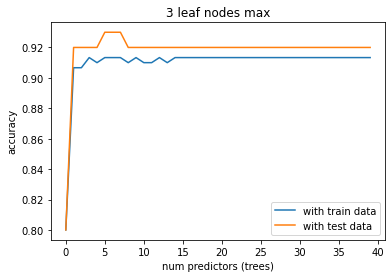

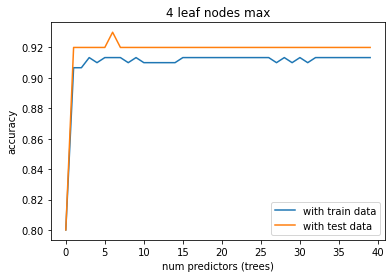

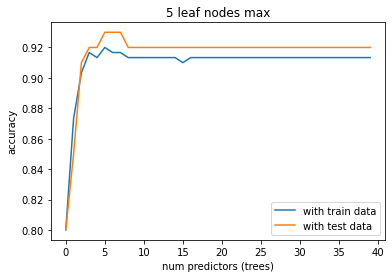

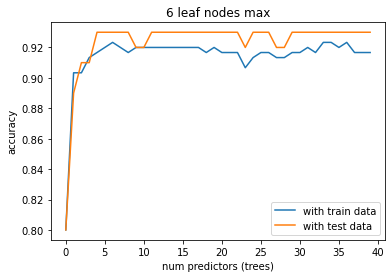

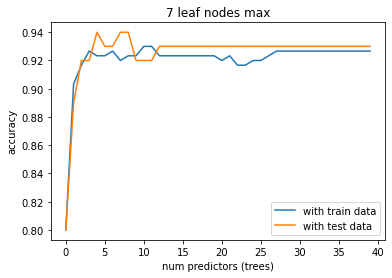

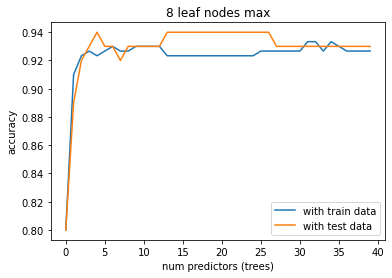

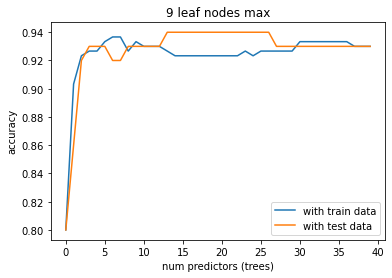

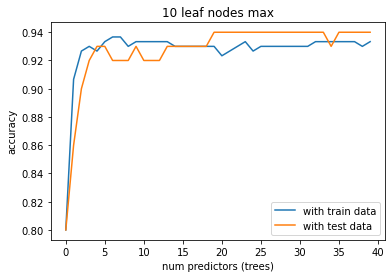

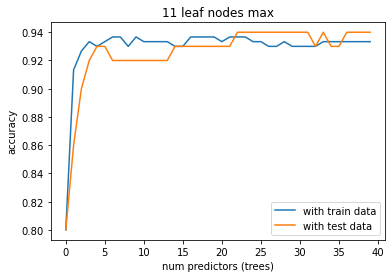

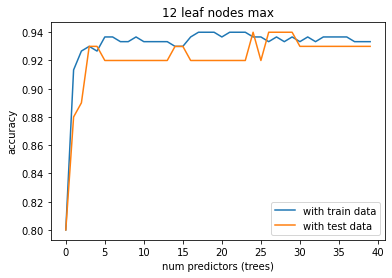

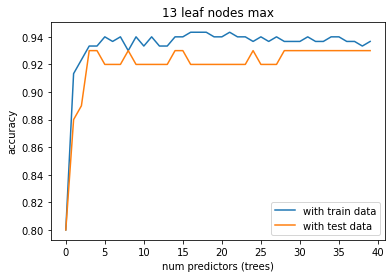

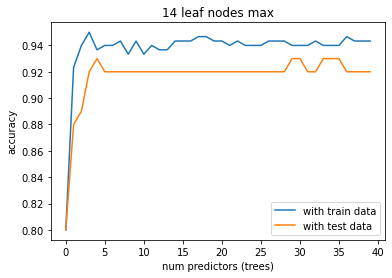

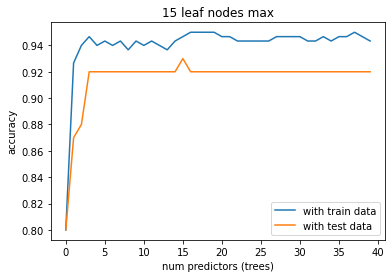

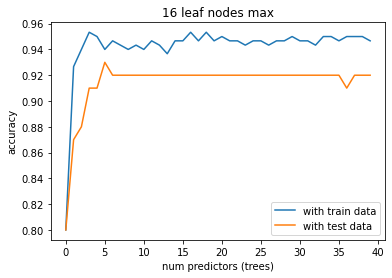

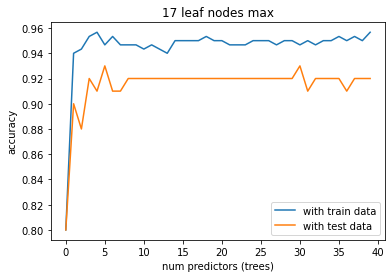

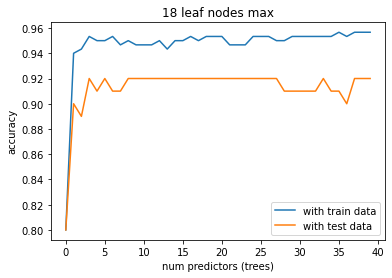

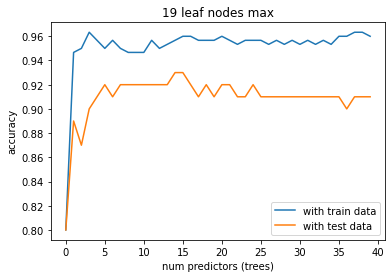

In [14]:
from sklearn.metrics import accuracy_score

max_predictors = 40
max_leaf_nodes = 20

for max_leaves in range(3, max_leaf_nodes):
    
    ns = [0]
    accs_test = [0.8]
    accs_train = [0.8]
    
    for n in range(1, max_predictors):

        ns.append(n)

        # create and train model with train data
        clf = RandomForestRegressor(n_estimators=n, 
                                    bootstrap=True,
                                    criterion='squared_error',
                                    max_leaf_nodes=max_leaves,
                                    min_samples_split=4,
                                    random_state=42)
        clf.fit(X_train, y_train)

        # predict train data and get accuracy
        y_prob_train = clf.predict(X_train)
        y_pred_train = np.array([round(y_probability) for y_probability in y_prob_train])
        accuracy_train = accuracy_score(y_train, y_pred_train)
        accs_train.append(accuracy_train)

        # test data
        y_prob_test = clf.predict(X_test)
        y_pred_test = np.array([round(y_probability) for y_probability in y_prob_test])
        accuracy_test = accuracy_score(y_test, y_pred_test)
        accs_test.append(accuracy_test)
    
    plt.plot(ns, accs_train)
    plt.plot(ns, accs_test)
    plt.legend(['with train data', 'with test data'])
    plt.xlabel('num predictors (trees)')
    plt.ylabel('accuracy')
    plt.title('{} leaf nodes max'.format(max_leaves))
    plt.show()

As maximum lumber of leaf nodes increases over 8 or 9, we get overfitting.

5 trees with 3 leaf nodes max are good enough to get practically the maximum accuracy, so this is the final selected random forest:

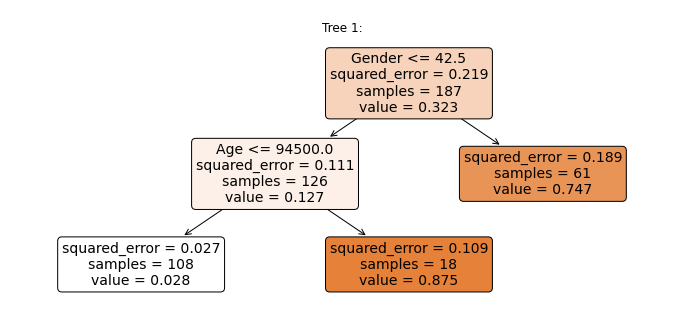

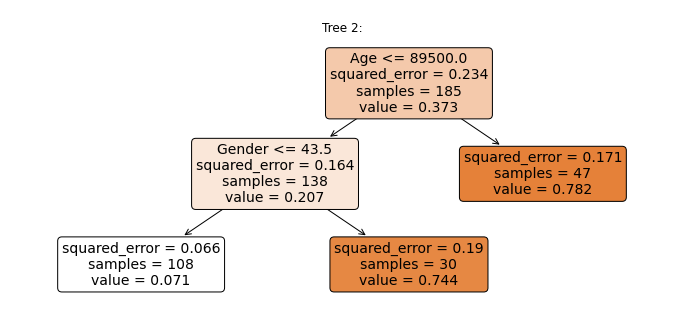

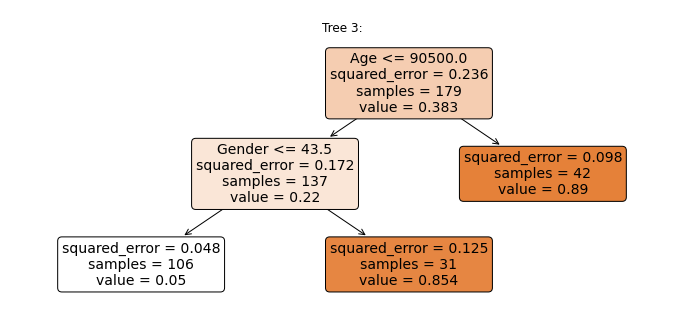

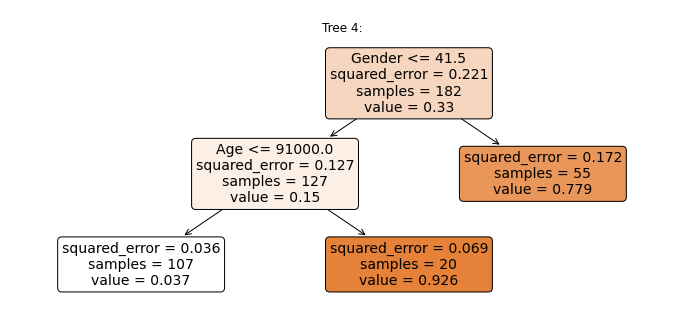

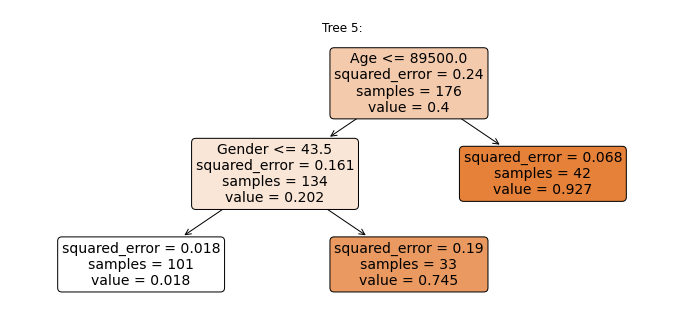

In [15]:
from sklearn.tree import plot_tree

max_leaf_nodes = 3
n_estimators = 5

clf = RandomForestRegressor(n_estimators=n_estimators, 
                            bootstrap=True,
                            criterion='squared_error',
                            max_leaf_nodes=max_leaf_nodes,
                            min_samples_split=4,
                            random_state=42)
clf.fit(X_train, y_train)

y_prob_test = clf.predict(X_test)
y_test = np.array([round(y_probability) for y_probability in y_prob_test])

for n in range(n_estimators):
    # first decision tree of random forest:
    tree_0 = clf.estimators_[n]
    plt.figure(figsize=(12,5))
    a = plot_tree(tree_0, 
                  feature_names=['Gender', 'Age', 'EstimatedSalary'],
                  class_names=['0', '1'], 
                  fontsize=14, filled=True, rounded=True)
    plt.title('\nTree {}:'.format(n + 1))
    plt.show()

Confusion matrix:

In [16]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
pd.DataFrame(cf_matrix, columns=['Predicted 0s','Predicted 1s'], index=['Actual 0s','Actual 1s'])

,Predicted 0s,Predicted 1s
Actual 0s,57,1
Actual 1s,4,38


Classification report:

In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96        58
           1       0.97      0.90      0.94        42

    accuracy                           0.95       100
   macro avg       0.95      0.94      0.95       100
weighted avg       0.95      0.95      0.95       100

